# Uplift Random Forest

In [1]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py/")

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [76]:
# Data generation
df, x_names = make_uplift_classification(n_samples=10000)

# Rename features for easy interpretation of visualization
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

df.head()

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5012,10000
treatment1,0.5160,10000
All,0.5086,20000


In [77]:
ntree = 20
max_depth = 3
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"

# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train

,treatment_group_key,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,conversion,treatment_effect
9971,treatment1,-0.819921,0.487782,0.088687,0.195483,0.706257,-0.155875,-0.881260,0.862554,0.443527,...,-0.809698,-0.358334,-1.794306,1.428480,0.970785,-0.477005,-0.723061,-0.616490,1,0
25157,treatment1,-0.353174,0.052905,-0.155964,0.072777,0.515159,0.566174,-0.192595,-0.378198,-0.856086,...,0.017410,0.068325,-0.758889,0.716809,0.455975,-1.649141,-1.306177,-1.289954,1,0
5435,control,-0.124757,-1.916619,-0.139645,0.410934,-0.360556,-2.753483,0.023516,0.060226,-0.655536,...,-0.622548,-0.193731,-1.298416,1.192059,0.994259,-1.716952,-1.307646,-1.260621,0,0
8512,treatment1,0.559197,0.505511,-0.683035,0.981752,-1.289639,1.429244,0.749478,-0.447672,1.732247,...,-2.324985,-0.659957,-1.352326,1.192179,1.174456,1.252325,0.820856,1.078238,0,0
30539,treatment1,-1.084370,2.737861,0.430030,0.226992,-0.512153,-1.622803,-0.764075,0.622148,-0.564899,...,-1.509591,-0.772224,-1.219498,1.316095,1.119828,-0.551075,-0.692443,-0.758716,1,0
34099,control,-0.232629,0.275596,0.699190,0.060479,0.734354,0.928374,-1.613356,1.464189,-1.466621,...,-0.116594,-0.321698,-0.304205,0.493367,0.240219,-1.103875,-1.100929,-0.862169,1,0
12202,control,1.638274,-1.506654,2.539072,0.698177,-0.825860,-1.068882,1.101930,-1.109676,0.130327,...,-0.887187,-1.353488,-1.817414,1.321724,1.185005,-0.516732,-0.731821,0.188834,0,0
7030,treatment1,-0.302026,-1.156957,-0.160747,0.597640,-0.730515,-0.813663,-0.538789,2.255744,-0.142023,...,-0.207502,-0.019635,-1.396282,1.212281,1.081657,0.115082,-0.390667,-0.020749,0,0
39155,control,0.619190,2.126525,-0.934364,-0.415301,0.233866,1.442398,-0.607546,-0.535892,0.275679,...,-1.320698,-0.159895,-1.954127,1.606493,1.200396,2.787235,-0.165169,2.187726,1,0
12312,control,0.476756,-2.707901,-1.393750,-1.148270,-0.652771,1.361593,0.819677,-0.241109,-1.250338,...,-0.565123,0.322685,-1.337792,1.140766,1.011131,-2.403173,-1.697079,-1.543594,0,0


## CausalML

In [78]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction='KL',
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[x_names].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

In [79]:
df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

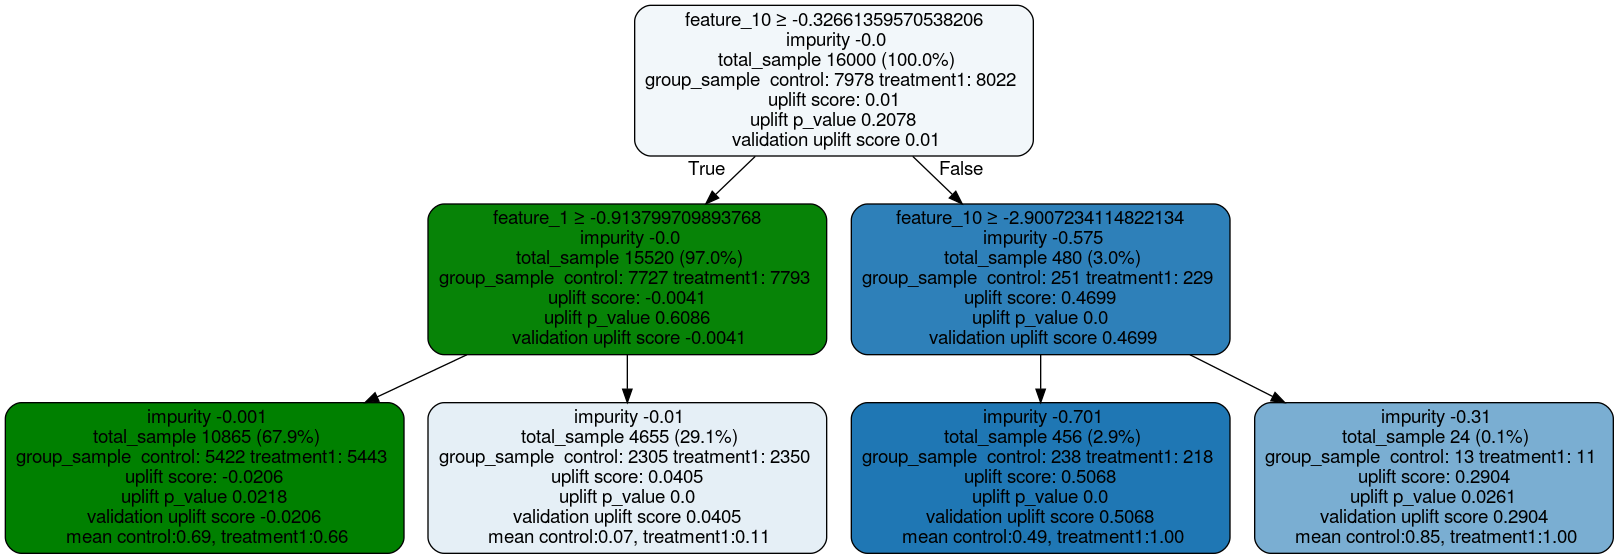

In [80]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, x_names)
Image(graph.create_png())

In [65]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[1].fitted_uplift_tree, x_names)
img = Image(graph.create_png())

In [66]:
for i in range(ntree):
    graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[i].fitted_uplift_tree, x_names)
    with open("/home/mori/Documents/h2o/code/test/uplift/causal_tree/causal_tee_"+str(i)+".png", "wb") as fout:
        fout.write(graph.create_png())

## H2O-3

In [41]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 1 hour 17 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.0.99999
H2O_cluster_version_age:,17 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.884 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [81]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            uplift_column=treatment_column,
            uplift_metric="KL",
            distribution="bernoulli",
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.99,
            auuc_type="gain"
)
h2o_uplift_model.train(y=response_column, x=x_names, training_frame=train_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf Model Build progress: |█████████████████████████████████████████| 100%


In [13]:
# Print H2O tree using Graphviz
def plot_trees(model, tree_index=None, dot_path='/home/mori/Documents/h2o/code/test/quantile_constraints/tree.dot'):
    try:
        import graphviz
        mojo_path = model.download_mojo()
        mojo_dot = h2o.print_mojo(mojo_path, format='dot')

        with open(dot_path, 'a') as the_file:
            the_file.write(mojo_dot)
        
        return graphviz.Source(mojo_dot)
    except:
        print("Error occured, propably graphviz is not installed.")

In [ ]:
plot_trees(h2o_uplift_model)

In [ ]:
model = h2o_uplift_model
mojo_path = model.download_mojo()
# print mojo fails
#mojo_dot = h2o.print_mojo(mojo_path, format='dot')

In [15]:
from h2o.tree import H2OTree, H2ONode

In [35]:
tree = H2OTree(h2o_uplift_model, 4, 1)
print(tree.tree_decision_path)

If ( feature_10 >= -0.0045502232 or feature_10 is NaN ) {

	If ( feature_9 >= -2.4658349 or feature_9 is NaN ) {
	
		Predicted value: 0.49501246
		
	} else {
	
		Predicted value: 0.875
		
	}
} else {

	Predicted value: 0.33333334
	
}


In [17]:
tree = H2OTree(h2o_uplift_model, 0, 0)
print(tree.tree_decision_path)

If ( feature_16 >= -2.1695595 or feature_16 is NaN ) {

	If ( feature_13 >= -0.9033042 or feature_13 is NaN ) {
	
		If ( feature_15 >= 1.9968942 ) {
		
			Predicted value: 0.61904764
			
		} else {
		
			Predicted value: 0.511502
			
		}
	} else {
	
		Predicted value: 0.14285715
		
	}
} else {

	Predicted value: 0.54545456
	
}


In [83]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)
preds_h2o[0] = preds_h2o[1] - preds_h2o[2]
    
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
mapping = {'treatment1': 1, 'control': 0}
results = results.replace({treatment_column: mapping})
results = results[["h2o", "causal", response_column, treatment_column]]

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf prediction progress: |██████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.08347948193550114,-0.061212400000000056,2.973064575195923e-05,,0.0
mean,0.012388539172272492,0.13804671688749987,0.1400668976943374,,0.5093125
maxs,0.27419046908617023,0.5032743500000001,0.5201598819355011,,1.0
sigma,0.018163301522601913,0.16049433042482583,0.14966569822840103,,0.4999288928436411
zeros,0,0,0,,7851
missing,0,0,0,0,0
0,0.010279369354248113,-0.0028877500000001888,0.013167119354248302,treatment1,1.0
1,0.010279369354248113,-0.006673700000000005,0.016953069354248118,treatment1,1.0
2,0.010279369354248113,0.05195519999999987,0.041675830645751755,control,0.0


min: 0.000030 max: 0.520160 mean: 0.140067


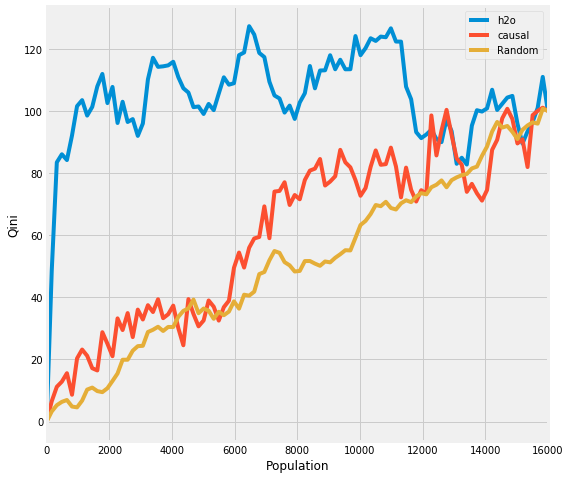

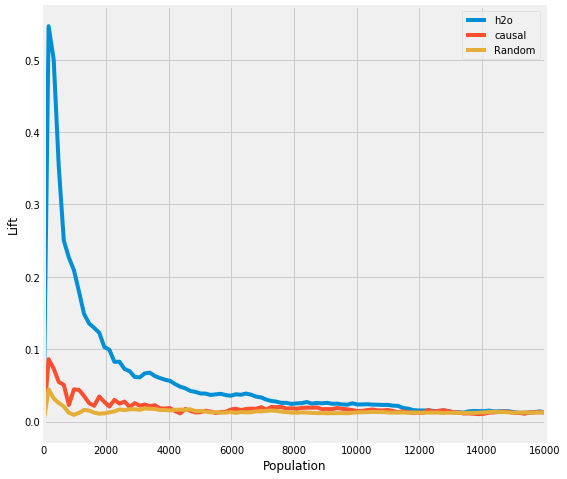

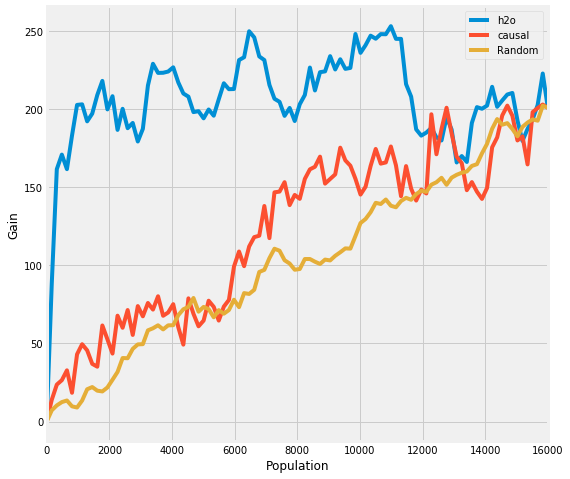

In [84]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

In [85]:
auuc_h2o = h2o_uplift_model.training_model_metrics()["AUUC"]
print("H2O metrics AUUC Gain: "+str(auuc_h2o))

auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O metrics AUUC Gain: 42.16341281716533
H2O AUUC:
206.309691981155
CauslML AUUC:
121.93274781845317
Random AUUC:
102.58204061669427
